# Classification of Sentinel-1  Time Series

SAR data are not especially good for vegetation classification. However they have the great advantage of being independent of cloud cover. Here we investigate the use of S1 time series over a complete growth period for thematic mapping.

Since we have no ground truth data, we will use the Canada AAFC Annual Crop Inventory, which is also on the GEE archive. In particular the 2017 inventory for an area in southern Saskatchewan. This area consists of large agricultural fields, well-defined crops, and flat terrain (a big advantage for SAR measurement).

Multilook SAR image data are not normally distributed, rather they are gamma distributed. The GEE classifiers might be expected not to work so well, so we will use Tensorflow to program a more flexible neural network classifier.

__First of all we grab a time series for the region of interest over the 2017 growing season (March to October):__

In [1]:
%matplotlib inline
import ee
from auxil.eeWishart import omnibus
ee.Initialize()
poly = ee.Geometry({'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-105.10328600000001, 50.24327999999998], 
                                                                           [-104.66649400000001, 50.24327999999998], 
                                                                           [-104.66649400000001, 50.46604134048255], 
                                                                           [-105.10328600000001, 50.46604134048255], 
                                                                           [-105.10328600000001, 50.24327999999998]]]})
collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
                      .filterBounds(poly) \
                      .filterDate(ee.Date('2017-03-01'), ee.Date('2017-11-01')) \
                      .filter(ee.Filter.eq('transmitterReceiverPolarisation', ['VV','VH'])) \
                      .filter(ee.Filter.eq('resolution_meters', 10)) \
                      .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                      .filter(ee.Filter.eq('relativeOrbitNumber_start',5)) \
                      .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))  
collection = collection.sort('system:time_start')

collection.size().getInfo()

19

__Next, we transform the collection into two multiband images with linear intensities, one pre-processed with the refined Lee filter and one not:__

In [6]:
from auxil.eeRL import refinedLee
import math

def get_vvvh(image):   
    ''' get 'VV' and 'VH' bands from sentinel-1 imageCollection and restore linear signal from db-values '''
    return image.select('VV','VH').multiply(ee.Image.constant(math.log(10.0)/10.0)).exp()

timeseries_rl = collection \
            .map(get_vvvh) \
            .map(refinedLee) \
            .toBands() \
            .clip(poly) \
            .float()    

timeseries_raw = collection \
            .map(get_vvvh) \
            .toBands() \
            .clip(poly) \
            .float()          

timeseries_rl.bandNames().length().getInfo()

38

__The class lables are conveniently obtained from the GEE archive of the Canadian AAFC Annual Crop Inventory for the year 2017, and we append them as an additional band (band 39):__ 

In [7]:
crop2017 = ee.ImageCollection('AAFC/ACI') \
    .filter(ee.Filter.date('2017-01-01', '2017-12-01')) \
    .first() \
    .clip(timeseries_raw.geometry())\
    .float()
labeled_timeseries_rl = ee.Image.cat(timeseries_rl,crop2017)
labeled_timeseries_raw = ee.Image.cat(timeseries_raw,crop2017)

labeled_timeseries_rl.bandNames().length().getInfo()

39

__Now export both images to the Google drive (cloud storage would be better, but I don't have a billing account). Note that the export scale is 30m corrresponding to the AAFC/ACI resolution:__

In [8]:
drexport1 = ee.batch.Export.image.toDrive(labeled_timeseries_rl,
                  description='driveExportTask', 
                  folder = 'EarthEngineImages',
                  fileNamePrefix='labeled_timeseries_rl',scale=30,maxPixels=1e10)
drexport1.start()
drexport2 = ee.batch.Export.image.toDrive(labeled_timeseries_raw,
                  description='driveExportTask', 
                  folder = 'EarthEngineImages',
                  fileNamePrefix='labeled_timeseries_raw',scale=30,maxPixels=1e10)
drexport2.start()

__After downloading from the drive to a local directory, we have:__

In [9]:
!ls -l imagery/regina

insgesamt 308676
-rw-rw-r-- 1 mort mort 158687709 Mär 12 15:08 labeled_timeseries_raw.tif
-rw-rw-r-- 1 mort mort 157381818 Mär 12 15:08 labeled_timeseries_rl.tif


__This displays three of the (filtered) VV bands and the last (label) band:__

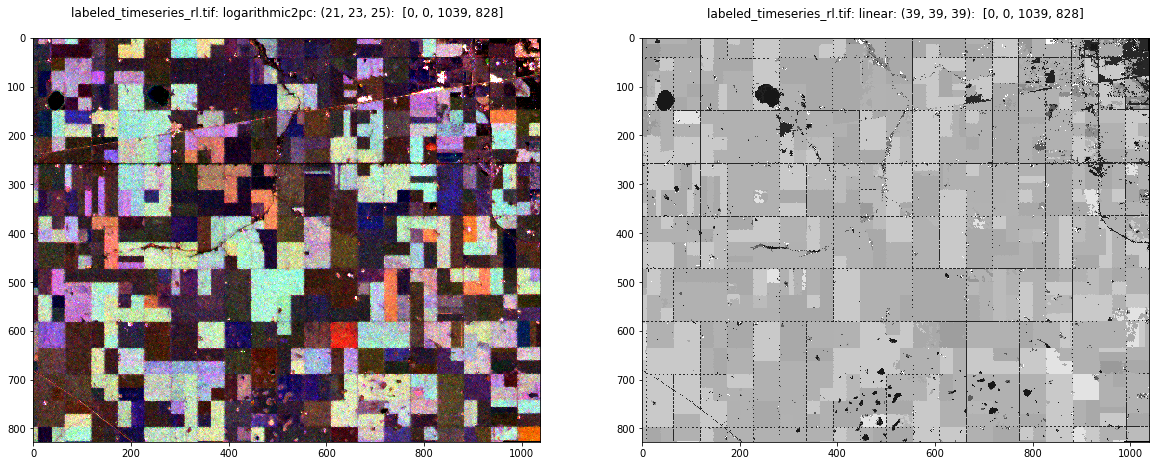

In [48]:
%run scripts/dispms -f imagery/regina/labeled_timeseries_rl.tif  -p [21,23,25] \
-F imagery/regina/labeled_timeseries_rl.tif -E 2 -P [39,39,39]

__Now read the labeled time series into two Numpy arrays, which we will use to train a Tensorflow NN classifier:__

In [17]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Byte
import numpy as np

gdal.AllRegister()                   
inDataset = gdal.Open('imagery/regina/labeled_timeseries_raw.tif',GA_ReadOnly)
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
labeled_timeseries_raw = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_timeseries_raw[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()   
labeled_timeseries_raw = np.nan_to_num(labeled_timeseries_raw)    

inDataset = gdal.Open('imagery/regina/labeled_timeseries_rl.tif',GA_ReadOnly)
labeled_timeseries_rl = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_timeseries_rl[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()   
labeled_timeseries_rl = np.nan_to_num(labeled_timeseries_rl)   

# for later
driver = inDataset.GetDriver() 
m = labeled_timeseries_raw.shape[0] 
inDataset = None

labeled_timeseries_raw.shape

(860292, 39)

__The AAFC/ACI thematic maps have 68 different classes. This code generates a dictionary of class names:__

In [23]:
classdict = {'0':'Nc'}
filepath = 'imagery/AAFC.txt'
with open(filepath) as fp:
    line = fp.readline()
    key = line[:3].replace('\t','')
    value = line[10:].replace('\t',' ').replace('\n','')
    classdict.update({key:value})
    while line:
        line = fp.readline()
        key = line[:3].replace('\t','')
        value = line[10:].replace('\t','').replace('\n','')
        classdict.update({key:value})
del classdict['']

len(classdict)

68

__Now we can see which class labels pertain to our region of interest:__

In [24]:
classnums = np.unique(labeled_timeseries_rl[:,-1])
print(classnums)
classnames = str([classdict[str(int(cn))] for cn in classnums])
classnames

[  0.  20.  30.  34.  50.  80. 110. 122. 131. 133. 136. 137. 145. 146.
 153. 154. 158. 162. 174. 193. 196. 220.]


"['Nc', 'Water', 'Exposed Land and Barren', 'Urban and Developed', 'Shrubland', 'Wetland', 'Grassland', 'Pasture and Forages', 'Fallow', 'Barley', 'Oats', 'Rye', 'Winter Wheat', 'Spring Wheat', 'Canola and Rapeseed', 'Flaxseed', 'Soybeans', 'Peas', 'Lentils', 'Herbs', 'Canaryseed', 'Broadleaf']"

__In order to train the neural network we have to renumber the labels consecutively from 0:__

In [26]:
i=0
labels = labeled_timeseries_rl[:,-1]
for c in classnums:
    labels = np.where(labels==c,i,labels)
    i += 1  
labels = np.array(labels,dtype=np.uint8) 
n_classes = len(np.unique(labels))
print(np.unique(labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


__Write the labels as an image to disk and display them:__

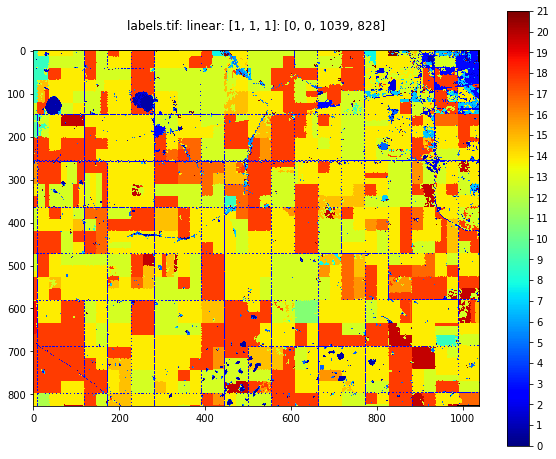

In [28]:
outDataset = driver.Create('imagery/regina/labels.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(labels,(rows,cols)))
outBand.FlushCache()
outDataset = None
%run scripts/dispms -f imagery/regina/labels.tif -c 

__Now we simulate ground truth by taking a random subset of training pixels, first for the unfiltered series:__

In [29]:
# random subset for training
np.random.seed(27)
n = 50000
idx = np.random.permutation(m)[0:n]
# training vectors
Xs = labeled_timeseries_raw[idx,:-1]*100

# one hot encoded class labels
Ls = np.array(labels[idx],dtype=np.int)
ls = np.zeros((n,n_classes))
for i in range(n):
    ls[i,Ls[i]] = 1
print(ls[0:5,:])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


__The module class auxil.dnn encapsulates a simple feed forward neural network using tf.keras.models.Sequential(). We use it with two hidden layers, each with 40 neurons, to classifiy the unfiltered time series:__

In [30]:
%%time
import auxil.dnn as dnn

classifier = dnn.Dnn([40,40],n_classes,learning_rate=0.002)
classifier.train(Xs,ls,epochs=100)

CPU times: user 4min 12s, sys: 14.4 s, total: 4min 27s
Wall time: 2min 58s


True

__The accuracy on the training and validation data is about 80%:__

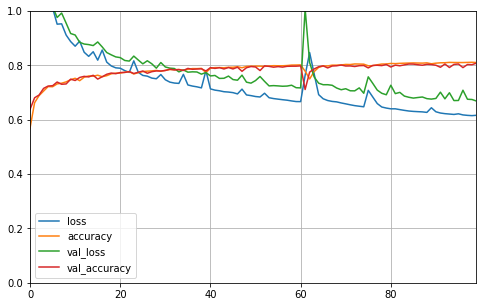

In [31]:
classifier.history()

__Now we Train on the Lee filtered series:__

In [32]:
np.random.seed(27)
n = 50000
idx = np.random.permutation(m)[0:n]
# training vectors  
Xs = labeled_timeseries_rl[idx,:-1]*100

classifier = dnn.Dnn([40,40],n_classes,learning_rate=0.002)
classifier.train(Xs,ls,epochs=100)

True

__And we have quite a substantial increase in classification accuracy (to about 86%):__

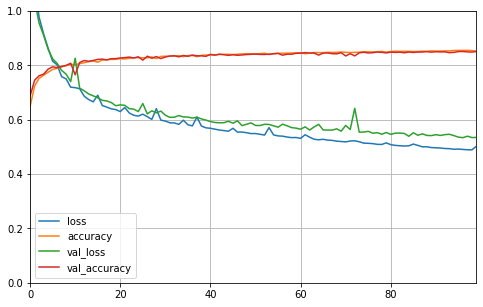

In [33]:
classifier.history()

__We'll use the filtered result to classify (predict) the entire image:__

In [42]:
cls,probs = classifier.classify(labeled_timeseries_rl[:,0:-1]*100) 
# for later display:
cls[0]=1
cls[1]=n_classes-1

probs.shape

(860292, 22)

__Write the thematic map and the class probabilities images to disk:__

In [43]:
# write the class image to disk
outDataset = driver.Create('imagery/regina/timeseries_rl_class.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(cls,(rows,cols)))
outBand.FlushCache()
outDataset = None
# write the class probabilities to disk
bands = probs.shape[1]
probs = np.byte(probs*255)
outDataset = driver.Create('imagery/regina/timeseries_rl_probs.tif',cols,rows,bands,GDT_Byte)
for b in range(bands):
    outBand = outDataset.GetRasterBand(b+1)
    outBand.WriteArray(np.reshape(probs[:,b],(rows,cols)))
    outBand.FlushCache()
outDataset = None

__Test the classifier with all of the training data (misclassification rate about 14.5%):__

In [39]:
classifier.test(Xs,ls)

0.14498

__Compare the classified image with the AAFC/ACI thematic map:__

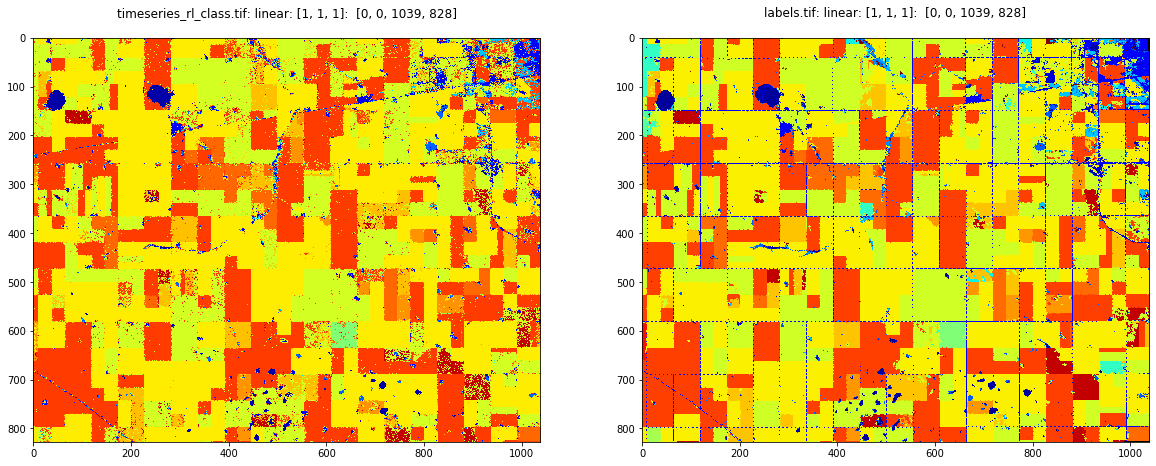

In [44]:
%run scripts/dispms -f imagery/regina/timeseries_rl_class.tif -c -F imagery/regina/labels.tif -C

__Looks good, but we can "pretty it up" some more with Probabilistic Label Relaxation (see Chapter 7 in my <a href= "https://www.amazon.com/Analysis-Classification-Change-Detection-Sensing/dp/1138613223/ref=dp_ob_title_bk">textbook</a>):__

       PLR
infile:  imagery/regina/timeseries_rl_probs.tif
iterations:  3
estimating compatibility matrix...
label relaxation...
iteration 1
iteration 2
iteration 3
result written to: imagery/regina/timeseries_rl_probs_plr.tif
elapsed time: 63.925615549087524
--done------------------------


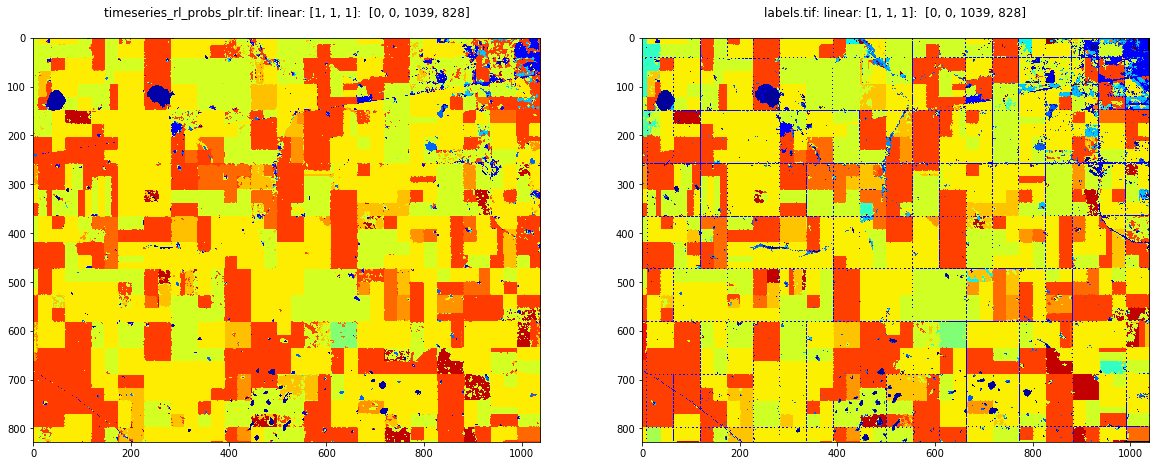

In [47]:
%run scripts/plr imagery/regina/timeseries_rl_probs.tif

%run scripts/dispms -f imagery/regina/timeseries_rl_probs_plr.tif -c  \
                    -F imagery/regina/labels.tif -C -s '/home/mort/Bilder/tmp.png'

__And I guess we're done.__

In [1]:
%run scripts/dispms -f imagery/regina/timeseries_rl_probs_plr.tif -c  \
                    -F imagery/regina/labels.tif -C -s '/home/mort/Bilder/tmp.png'

<Figure size 2000x1000 with 2 Axes>